# Prepare Census Block OD Data
---

In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import json
import requests
import pickle

from bikewaysim.paths import config
from bikewaysim.framework import bikewaysim_functions

# Retrieve LODES7 data

In [2]:
state_two_letter = "ga"
YYYY = 2010
lodes_url_base = f"https://lehd.ces.census.gov/data/lodes/LODES7/{state_two_letter}/od/{state_two_letter}_od_main_JT00_{YYYY}.csv.gz"
lodes = pd.read_csv(lodes_url_base)

#processs df
rename_dict = {
    'w_geocode':'work_blockid',
    'h_geocode':'home_blockid',
    'S000': 'total_jobs'  
}
lodes.rename(columns=rename_dict, inplace=True)
lodes = lodes[['work_blockid','home_blockid','total_jobs']]


# Census Blocks

In [3]:
#study area for masking blocks
studyarea = gpd.read_file(config['studyarea_fp'])#.to_crs(config['projected_crs_epsg'])
studyarea = studyarea.unary_union.envelope

/var/folders/66/68r0k8s534v4gf9flsfnxnsr0000gn/T/ipykernel_43907/241065491.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  studyarea = studyarea.unary_union.envelope


In [5]:
config.keys()

dict_keys(['project_fp', 'raw_data_fp', 'projected_crs_epsg', 'geofabrik_year', 'geofabrik_state', 'usgs_fp', 'here_fp', 'gdot_road_inventory_fp', 'gdot_traffic_fp', 'gdot_signals_fp', 'coa_bike_fp', 'arc_bike_fp', 'basemap_api_keys', 'mod_name', 'bicycle_facilities_fp', 'bikewaysim_fp', 'calibration_fp', 'cycleatl_fp', 'matching_fp', 'network_fp', 'osmdwnld_fp', 'scratch_fp', 'figures_fp', 'geofabrik_fp', 'studyarea_fp'])

In [8]:
#bring in census blocks (get from https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
#TODO script downloading the blocks
#move into bikewaysim_fp and rename to census_blocks
blocks = gpd.read_file(config['bikewaysim_fp'] / "census_blocks.zip",mask=studyarea).to_crs(config['projected_crs_epsg'])
blocks.rename(columns={'GEOID20':'blockid'},inplace=True)
blocks = blocks[['blockid','geometry']]

# Data Wrangling

In [9]:
#make sure type are the same
lodes['work_blockid'] = lodes['work_blockid'].astype(int)
lodes['home_blockid'] = lodes['home_blockid'].astype(int)
blocks['blockid'] = blocks['blockid'].astype(int)

In [10]:
#filter lodes data
print('lodes:',lodes.shape[0],'blocks:',blocks.shape[0])
lodes = lodes[lodes['work_blockid'].isin(blocks['blockid']) & lodes['home_blockid'].isin(blocks['blockid'])]
blocks = blocks[blocks['blockid'].isin(lodes['work_blockid']) | blocks['blockid'].isin(lodes['home_blockid'])]
print('lodes:',lodes.shape[0],'blocks:',blocks.shape[0])

lodes: 3196531 blocks: 1112
lodes: 518 blocks: 195


Only 3 mile trips

In [11]:
block_geo = dict(zip(blocks['blockid'],blocks['geometry'].centroid))
home = gpd.GeoSeries(lodes['home_blockid'].map(block_geo),crs=blocks.crs)
work = gpd.GeoSeries(lodes['work_blockid'].map(block_geo),crs=blocks.crs)
lodes = lodes[home.distance(work) <= 3 * 5280]

In [12]:
#rename to make it easier to work with teh code for tazs
#assume home is the origin
lodes.columns = ['dest_taz','orig_taz','trips']
blocks.columns = ['tazid','geometry']

# Snap OD pairs to network

In [13]:
# import network nodes
nodes = gpd.read_file(config['network_fp']/"final_network.gpkg",layer="nodes")

with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
del turns

nodes0 = pd.concat([links['A'],links['B']]).unique().tolist()
nodes = nodes[nodes['N'].isin(nodes0)]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tannerpassmore/Documents/BikewaySim/propel/Calibration/calibration_network.pkl'

In [17]:
blocks = bikewaysim_functions.snap_ods_to_network(blocks,nodes)

#knock out if over 1000 feet
blocks = blocks[blocks['dist']<=500]

In [18]:
snapped_ods = dict(zip(blocks['tazid'],blocks['N']))
lodes['orig_N'] = lodes['orig_taz'].map(snapped_ods)
lodes['dest_N'] = lodes['dest_taz'].map(snapped_ods)

In [19]:
lodes.dropna(inplace=True)

In [20]:
trip_origins_per_taz = lodes.groupby('orig_taz')['trips'].sum().reset_index()
trip_origins_per_taz.columns = ['tazid','trip_origins']

In [21]:
# no trips
no_trips = blocks[blocks['tazid'].isin(trip_origins_per_taz['tazid'])==False]
no_trips

,tazid,geometry,N,dist
11,130890201001035,"POLYGON ((2241464.825 1380022.726, 2241459.966...",68355802,148.050947
14,130890205001001,"POLYGON ((2241113.924 1367665.226, 2241113.96 ...",5422266435,299.791333
22,130890205001005,"POLYGON ((2241120.373 1366844.326, 2241119.631...",68340167,460.728311
23,130890202002009,"POLYGON ((2241771.343 1374112.929, 2241858.139...",68191996,75.385458
44,130890205001002,"POLYGON ((2242210.535 1368052.28, 2242506.651 ...",5416016260,422.371607
...,...,...,...,...
897,131210119002021,"POLYGON ((2229422.42 1366982.195, 2229406.625 ...",9588006179,119.993629
898,131210119002028,"POLYGON ((2229476.982 1366204.489, 2229437.786...",8199608314,233.281442
900,131210005001059,"POLYGON ((2227152.491 1379369.674, 2227151.036...",5999239846,152.124247
901,131210005001010,"POLYGON ((2228795.773 1381464.522, 2228478.6 1...",1783828102,365.619068


In [22]:
blocks = blocks.merge(trip_origins_per_taz,on='tazid')

In [23]:
blocks.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')

In [24]:
# trip origins per TAZ
#export the taz areas
blocks.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')
#export the taz centroids
taz_centroids = blocks.copy().to_crs(config['projected_crs_epsg'])
taz_centroids.geometry = taz_centroids.geometry.centroid
taz_centroids.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_centroids')

<Axes: >

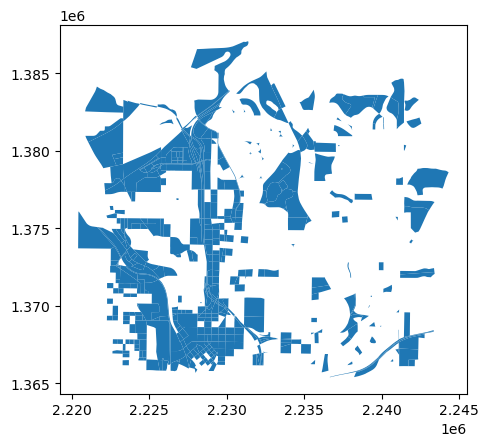

In [25]:
studyarea = gpd.read_file(config['studyarea_fp'])
blocks0 = gpd.read_file("/Users/tannerpassmore/Documents/BikewaySim/Savannah/OD Creation/tl_2010_13_tabblock10.shp",mask=studyarea).to_crs(config['projected_crs_epsg'])
blocks0.rename(columns={'GEOID10':'tazid'},inplace=True)
blocks0['tazid'] = blocks0['tazid'].astype(int)
blocks0 = blocks0[['tazid','geometry']]
blocks0 = blocks0[blocks0['tazid'].isin(blocks['tazid'])==False]
blocks0.plot()

In [ ]:
# useful for visiualization
blocks0.to_file(config['bikewaysim_fp']/'ods.gpkg',layer='filtered_out_or_zero')

# Export

In [27]:
print(lodes['trips'].sum(),'trips across',lodes.shape[0],'unique OD pairs')#,tripData['hh_id'].nunique(),'persons')
print('and',blocks.shape[0],'census blocks')

8992 trips across 7016 unique OD pairs
and 647 census blocks


In [28]:
# #export the taz areas
# blocks.to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='block_polygons')

# #export the taz centroids
# blocks_centroids = blocks.copy()
# blocks_centroids.geometry = blocks_centroids.geometry.centroid
# blocks_centroids.to_crs(config['projected_crs_epsg']).to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='block_centroids')

#export the ods
lodes.to_csv(config['bikewaysim_fp']/'od_matrix.csv',index=False)

Exploring past here

In [ ]:
lodes

In [ ]:
# works = lodes[['work_blockid','total_jobs']].copy()
# works = works.groupby('work_blockid')['total_jobs'].sum().reset_index()
# works = pd.merge(works,blocks[['blockid','geometry']],left_on="work_blockid",right_on='blockid')
# works = gpd.GeoDataFrame(works,geometry='geometry')
# works.explore('total_jobs')
# merged = pd.merge(lodes,blocks[['blockid','geometry']],left_on="work_blockid",right_on='blockid',how='left')
# merged.drop(columns=['blockid'],inplace=True)
# merged.rename(columns={'geometry':'work_geo'},inplace=True)
# merged = pd.merge(merged,blocks[['blockid','geometry']],left_on="home_blockid",right_on='blockid',how='left')
# merged.drop(columns=['blockid'],inplace=True)
# merged.rename(columns={'geometry':'home_geo'},inplace=True)
# merged = merged[merged['home_geo'].notna() & merged['work_geo'].notna()]
# random_id = merged['work_blockid'].sample(1).item()
# subset = merged.loc[merged['work_blockid']==random_id].copy()
# subset = gpd.GeoDataFrame(subset,geometry='home_geo')
# m = subset.explore()
# blocks.loc[blocks['blockid']==random_id,'geometry'].explore()
# work = blocks.loc[blocks['blockid']==random_id,'geometry'].to_crs('epsg:4326').item().centroid
# x, y = list(work.coords)[0]
# import folium
# folium.Circle((y,x),radius=100,tooltip='WORK',kwargs={'color':'green'}).add_to(m)
# m
# merged['work_geo'] = gpd.GeoSeries(merged['work_geo']).centroid
# merged['home_geo'] = gpd.GeoSeries(merged['home_geo']).centroid
# # import geopandas as gpd
# # import pandas as pd
# # from pathlib import Path
# # import json

# # config = json.load((Path.cwd().parent / 'config.json').open('rb'))
# # network_fp = Path(config['project_directory']) / "Network"
# # osmdwnld_fp = Path(config['project_directory']) / "OSM_Download"
# # elevation_fp = Path(config['project_directory']) / "Elevation"
# # cyclinginfra_fp = Path(config['project_directory']) / "Cycling_Infra_Dating"
# # calibration_fp = Path(config['project_directory']) / "Calibration"



# #'foot' in blocks.crs.axis_info[0].unit_name

# #df.crs.axis_info[0].unit_name